<a href="https://colab.research.google.com/github/PaprikaSteiger/CNN_GAN_tensorflow_vs_pytorch/blob/master/cnngan_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a CNNGAN with pytroch

## 1. Import and Preprocessing
### a) Importing modules

In [59]:
# Load required packages - data handling & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Load required packages - deep learning 
import torch
import torch.nn as nn
import torch.optim as optim

In [60]:
print(f"tensorflow: {torch.__version__}")
import sys
print(f"python: {sys.version[:5]}")

tensorflow: 1.8.1+cu101
python: 3.7.1


### b) Importing the data

In [61]:
# I exceeded my git LFS bandwidth limit for this month, thus the file cannot be loaded from git
#train_data = pd.read_csv('https://media.githubusercontent.com/media/PaprikaSteiger/CNN_GAN_tensorflow_vs_pytorch/master/fashion-mnist_train.csv')

# load directly from keras and transform to pandas
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
y_train = y_train.reshape((-1,1))
x_train = x_train.reshape((-1, 28*28))
x_train = np.concatenate([y_train, x_train], axis=1)
labels = ["label"] + [f"pixel{i}" for i in range(1,785)]
train_data = pd.DataFrame(x_train,columns=labels, index=list(range(60000)))
del x_train
del y_train
del x_test
del y_test

# or load from other git repo from mmeirer
#train_data = pd.read_csv('https://media.githubusercontent.com/media/mmeierer/CNN---TensorFlow-vs-PyTorch/main/fashion-mnist_train.csv')

In [62]:
train_data.head()

In [63]:
train_images = train_data.iloc[:,1:]

In [64]:
plt.figure()
plt.imshow(train_images.values[0].reshape(28,28), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c) Data preparation

In [65]:
# use maximum normalization
train_images = train_images / np.float32(255)

In [66]:
train_images.head()


## 2. Model specific data preparation (tensorflow)
## a) Load the data

In [106]:

x_train_pt = torch.from_numpy(train_images.values.reshape((-1, 1, 28, 28)))

(60000, 28, 28)
(60000, 28, 28)


### b) Tensor view of the data

In [68]:
x_train_pt.shape

torch.Size([60000, 1, 28, 28])

In [69]:
x_train_pt[0][0][5]

tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0,
        102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,  10,   0],
       dtype=torch.uint8)

## 3. Model definition

In [70]:
def weights_init(m):
  if isinstance(m, nn.Linear):
      nn.init.uniform_(m.weight.data, -1,1)
      nn.init.zeros_(m.bias.data)
  if isinstance(m, nn.Conv2d):
      nn.init.uniform_(m.weight.data, -1, 1)
      nn.init.zeros_(m.bias.data)
  if isinstance(m, nn.ConvTranspose2d):
      nn.init.uniform_(m.weight.data, -1, 1)
      nn.init.zeros_(m.bias.data)

### a.1) Generator

In [72]:
def generator_model():
    model = nn.Sequential()
    model.add_module("Conv2D1", nn.ConvTranspose2d(100, 64, 7, stride=1, padding=0, bias=True))
    model.add_module("Batchnorm1", nn.BatchNorm2d(64))
    model.add_module("LeakyRelu1", nn.LeakyReLU())
    
    model.add_module("Conv2D2", nn.ConvTranspose2d(64, 32, (8,8), stride=(1,1), padding=0, bias=True))
    model.add_module("Batchnorm2", nn.BatchNorm2d(32))
    model.add_module("LeakyRelu2", nn.LeakyReLU())
    
    model.add_module("Conv2D3", nn.ConvTranspose2d(32, 1, (15,15), stride=1, padding=0, bias=True))
    model.add_module("Batchnorm3", nn.BatchNorm2d(1))
    model.add_module("Sigmoid1", nn.Sigmoid())
    return model
generator = generator_model()

###  a.2) Inspect the generator model

In [73]:
print(generator)

Sequential(
  (Conv2D1): ConvTranspose2d(100, 64, kernel_size=(7, 7), stride=(1, 1))
  (Batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Conv2D2): ConvTranspose2d(64, 32, kernel_size=(8, 8), stride=(1, 1))
  (Batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): ConvTranspose2d(32, 1, kernel_size=(15, 15), stride=(1, 1))
  (Batchnorm3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Sigmoid1): Sigmoid()
)


In [74]:
generator.apply(weights_init)

Sequential(
  (Conv2D1): ConvTranspose2d(100, 64, kernel_size=(7, 7), stride=(1, 1))
  (Batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Conv2D2): ConvTranspose2d(64, 32, kernel_size=(8, 8), stride=(1, 1))
  (Batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): ConvTranspose2d(32, 1, kernel_size=(15, 15), stride=(1, 1))
  (Batchnorm3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Sigmoid1): Sigmoid()
)

In [75]:
# generated image not trained
fake_im_not_trained = generator(torch.normal(0, 1, size=[1, 100, 1, 1]))
# check output shape of generator
fake_im_not_trained

tensor([[[[0.5838, 0.6018, 0.5575, 0.5422, 0.5500, 0.5899, 0.5934, 0.6559,
           0.5163, 0.5700, 0.4956, 0.5367, 0.5586, 0.5671, 0.5125, 0.6196,
           0.5434, 0.6048, 0.6331, 0.5764, 0.5877, 0.6262, 0.6030, 0.5689,
           0.5608, 0.5858, 0.5707, 0.5742],
          [0.5838, 0.5794, 0.5652, 0.5508, 0.5163, 0.4510, 0.4086, 0.3875,
           0.3034, 0.4191, 0.5731, 0.4465, 0.3978, 0.5723, 0.3962, 0.3378,
           0.6273, 0.5639, 0.4473, 0.6241, 0.4467, 0.6042, 0.5622, 0.4223,
           0.5488, 0.5829, 0.5558, 0.5748],
          [0.5581, 0.5668, 0.5114, 0.5018, 0.3993, 0.5551, 0.4732, 0.5869,
           0.7087, 0.4186, 0.6406, 0.3950, 0.5416, 0.4517, 0.4282, 0.5612,
           0.6770, 0.5494, 0.3830, 0.5276, 0.4933, 0.5910, 0.5739, 0.6133,
           0.5093, 0.6337, 0.5732, 0.5840],
          [0.5957, 0.6278, 0.5952, 0.5887, 0.5849, 0.5756, 0.2772, 0.7221,
           0.5673, 0.5214, 0.4656, 0.4011, 0.5246, 0.2798, 0.4864, 0.5342,
           0.5443, 0.6112, 0.5530, 0.6365, 

### a.3) Inspect the first convolutional layer

In [76]:
generator[0].weight[0]

tensor([[[-0.5011, -0.6191, -0.9341,  ...,  0.7406, -0.2029,  0.4036],
         [-0.0024,  0.2560,  0.2896,  ...,  0.2225,  0.3449, -0.4250],
         [ 0.2470,  0.6154, -0.0742,  ..., -0.9643, -0.3473, -0.9829],
         ...,
         [-0.0866,  0.8987, -0.6708,  ..., -0.9191,  0.2368,  0.8779],
         [ 0.9250, -0.9830, -0.7157,  ..., -0.4578, -0.6849, -0.1276],
         [-0.0781, -0.7013, -0.6687,  ..., -0.8546,  0.1641,  0.1915]],

        [[ 0.0666,  0.2940, -0.8431,  ...,  0.3490, -0.7478,  0.7524],
         [-0.5806, -0.0768, -0.4083,  ..., -0.1030,  0.5677, -0.3974],
         [ 0.6096,  0.8563,  0.2462,  ..., -0.1422, -0.2535,  0.1392],
         ...,
         [-0.8995, -0.8434, -0.1207,  ...,  0.2057, -0.2994, -0.0379],
         [-0.3850,  0.7597, -0.4739,  ..., -0.0880,  0.8367, -0.0556],
         [ 0.1200, -0.7393, -0.7042,  ..., -0.5302, -0.2689,  0.0864]],

        [[-0.1631, -0.7582,  0.1294,  ...,  0.6792,  0.6041, -0.8709],
         [-0.0821,  0.8933, -0.8220,  ..., -0

In [77]:
generator[0].weight.shape

torch.Size([100, 64, 7, 7])

In [78]:
generator[0].bias

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [79]:
generator[0].bias.shape

torch.Size([64])

### b.1) Discriminator

In [80]:
def discriminator_model():
    model = nn.Sequential()
    model.add_module("Conv2D1", nn.Conv2d(1, 2, kernel_size=5, stride=1, padding=2))
    model.add_module("Pooling1", nn.AvgPool2d(kernel_size=2, stride=2))
    model.add_module("LeakyRelu1", nn.LeakyReLU())
    model.add_module("Dropout1", nn.Dropout(0.3))
    
    model.add_module("Conv2D2", nn.Conv2d(2, 2, kernel_size=5, stride=1, padding=2))
    model.add_module("LeakyRelu2", nn.LeakyReLU())
    
    model.add_module("Conv2D3", nn.Conv2d(2, 1, kernel_size=5, stride=1, padding=0))
    model.add_module("LeakyRelu3", nn.LeakyReLU())
    
    model.add_module("Flatten1", nn.Flatten())
    
    model.add_module("Dense1", nn.Linear(100,100))
    model.add_module("LeakyRelu4", nn.LeakyReLU())
    
    model.add_module("Dense2", nn.Linear(100,64))
    model.add_module("Tanh", nn.Tanh())
    
    model.add_module("Dense3", nn.Linear(64,1))
    model.add_module("Sigmoid", nn.Sigmoid())
    return model
discriminator = discriminator_model()

### b.2) Inspect the discriminator model

In [81]:
print(discriminator)
discriminator(fake_im_not_trained)

Sequential(
  (Conv2D1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (Conv2D2): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1))
  (LeakyRelu3): LeakyReLU(negative_slope=0.01)
  (Flatten1): Flatten(start_dim=1, end_dim=-1)
  (Dense1): Linear(in_features=100, out_features=100, bias=True)
  (LeakyRelu4): LeakyReLU(negative_slope=0.01)
  (Dense2): Linear(in_features=100, out_features=64, bias=True)
  (Tanh): Tanh()
  (Dense3): Linear(in_features=64, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)


tensor([[0.4841]], grad_fn=<SigmoidBackward>)

In [82]:
discriminator.apply(weights_init)

Sequential(
  (Conv2D1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (Conv2D2): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1))
  (LeakyRelu3): LeakyReLU(negative_slope=0.01)
  (Flatten1): Flatten(start_dim=1, end_dim=-1)
  (Dense1): Linear(in_features=100, out_features=100, bias=True)
  (LeakyRelu4): LeakyReLU(negative_slope=0.01)
  (Dense2): Linear(in_features=100, out_features=64, bias=True)
  (Tanh): Tanh()
  (Dense3): Linear(in_features=64, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)

### b.3) Inspect the first convolutional layer

In [83]:
discriminator[0].weight[0].type()

'torch.FloatTensor'

In [84]:
discriminator[0].weight.shape

torch.Size([2, 1, 5, 5])

In [85]:
discriminator[0].bias

Parameter containing:
tensor([0., 0.], requires_grad=True)

In [86]:
discriminator[0].bias.shape

torch.Size([2])

## 4. Loss & Optimizer

### 4.a) Generator loss

In [87]:
cross_entropy = nn.BCEWithLogitsLoss()
def generator_loss(fake_output):
    return cross_entropy(torch.ones_like(fake_output), fake_output)

### 4.b) Discriminator loss

In [88]:
def real_discriminator_loss(real_output):
    return  cross_entropy(torch.ones_like(real_output), real_output)

def fake_discriminator_loss(fake_output):
    return cross_entropy(torch.zeros_like(fake_output), fake_output)

## 4.c) Optimizers

In [89]:
generator_optimizer = optim.Adam(generator.parameters(), lr=1e-2)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-2)

def correct_classification(y_true, y_prob):
    assert y_true.size() == y_prob.size()
    y_prob = (y_prob > 0.5).float()
    return (y_true == y_prob).sum().item()

## 5. Training

In [90]:
# This annotation causes the function to be "compiled".
#@tf.function
def train_step_pt(generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size = 100):
    gen_loss_tot = []
    disc_loss_tot = []
    disc_acc_real_tot = 0
    disc_acc_fake_tot = 0
    generator.train()
    discriminator.train()
    for beg_i in range(0, x_train_pt.shape[0], batch_size):
        x_train_batch_pt = x_train_pt[beg_i:beg_i + batch_size]

        x_fake_batch_pt = torch.normal(0, 1, size=[batch_size, 100, 1, 1])
        
        discriminator_optimizer.zero_grad()
        real_output = discriminator(x_train_batch_pt.float()).view(-1)
        disc_loss_real = real_discriminator_loss(real_output)
        disc_loss_real.backward()
        
        generated_images = generator(x_fake_batch_pt)
        fake_output = discriminator(generated_images.detach()).view(-1)
        disc_loss_fake = fake_discriminator_loss(fake_output)
        disc_loss_fake.backward()
        err = disc_loss_fake + disc_loss_real
        discriminator_optimizer.step()
        
        # optimize generator
        generator_optimizer.zero_grad()
        fake_output = discriminator(generated_images.detach()).view(-1)
        gen_loss = generator_loss(fake_output)
        gen_loss.backward()
        generator_optimizer.step()
        
        gen_loss_tot.append(gen_loss.mean().item())
        disc_loss_tot.append(err.mean().item())
        disc_acc_real_tot += correct_classification(torch.ones_like(real_output), real_output)
        disc_acc_fake_tot += correct_classification(torch.zeros_like(fake_output), fake_output)

    disc_acc_real_tot = disc_acc_real_tot/x_train_pt.size(0)
    disc_acc_fake_tot = disc_acc_fake_tot/x_train_pt.size(0)
    print([disc_acc_real_tot, disc_acc_fake_tot])
    disc_acc_tot = np.mean([disc_acc_real_tot, disc_acc_fake_tot])
    return gen_loss_tot, disc_loss_tot, disc_acc_tot

In [91]:
train_losses_generator_pt = []
train_losses_discriminator_pt = []
train_acc_discriminator_pt = []
epochs = 15
start = time.time()
for epoch in range(epochs):
    gen_loss, disc_loss, disc_acc = train_step_pt(generator, discriminator, generator_optimizer, discriminator_optimizer)
    gen_loss = np.mean(gen_loss)
    disc_loss = np.mean(disc_loss)
    train_losses_generator_pt.append(gen_loss)
    train_losses_discriminator_pt.append(disc_loss)
    train_acc_discriminator_pt.append(disc_acc*100)


    template = ("Epoch {}, Loss_Generator: {}, Loss_Discriminator: {}, Discriminator_Accuracy: {}")
    print(template.format(epoch+1, gen_loss, disc_loss, disc_acc*100))
end = time.time()
print(f"Total training time{(end - start)/60.0}")

[0.9800833333333333, 0.01865]
Epoch 1, Loss_Generator: 0.3325158628821373, Loss_Discriminator: 1.0266333564122518, Discriminator_Accuracy: 49.93666666666666
[1.0, 0.0]
Epoch 2, Loss_Generator: 0.3132616951068242, Loss_Discriminator: 1.0064090577761333, Discriminator_Accuracy: 50.0
[1.0, 0.0]
Epoch 3, Loss_Generator: 0.3132616650064786, Loss_Discriminator: 1.0064088588953017, Discriminator_Accuracy: 50.0
[1.0, 0.0]
Epoch 4, Loss_Generator: 0.3132616612315178, Loss_Discriminator: 1.0064118939638138, Discriminator_Accuracy: 50.0


KeyboardInterrupt: ignored

In [ ]:
print(f"Total training time{(end - start)/60.0}")

### b) Training progress

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(train_acc_discriminator_pt)
plt.title('discriminator accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['discriminator_train'], loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(train_losses_generator_pt)
plt.plot(train_losses_discriminator_pt)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper right')
plt.show()

### c1) Generator output before training

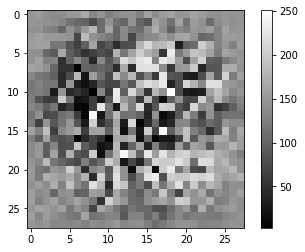

In [92]:

fake_im_not_trained = fake_im_not_trained.detach().numpy() * 255
fake_im_not_trained = fake_im_not_trained.reshape((28,28))
plt.figure()
plt.imshow(fake_im_not_trained, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c2) Generator output after training

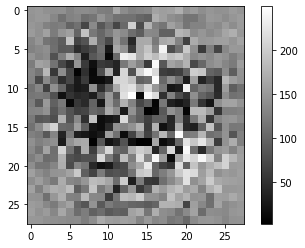

In [93]:
seed2 = torch.normal(0, 1, size=[1, 100, 1, 1])
generator.train(False)
fake_im = generator(seed2)
fake_im = fake_im.detach().numpy() * 255
fake_im = fake_im.reshape((28,28))
plt.figure()
plt.imshow(fake_im, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

## 6. References
The presented model is based on a combination of two tutorials for deep cnn-gans:
1) https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

2) https://www.tensorflow.org/tutorials/generative/dcgan